In [1]:
#importing Libraries

import numpy as np
import tensorflow as tf
import torch
import scipy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F




In [2]:
#converting image into tensor
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])




# Load the entire training dataset
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Split the data into training and validation sets
train_size = int(0.8 * len(full_trainset))
valid_size = len(full_trainset) - train_size
trainset, validset = torch.utils.data.random_split(full_trainset, [train_size, valid_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

validloader = torch.utils.data.DataLoader(validset, batch_size=4,
                                          shuffle=False, num_workers=2)

#testset + labels
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



100%|██████████| 170498071/170498071 [00:12<00:00, 13157960.67it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [15]:
#CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.conv3 = nn.Conv2d(64, 128, 3,  padding=2)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=2)
        self.conv5 = nn.Conv2d(256, 512, 3, padding=2)

        self.fc1 = nn.Linear(2048, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))
        x = self.pool(F.leaky_relu(self.conv4(x)))
        x = self.pool(F.leaky_relu(self.conv5(x)))

        x = x.view(-1, 2048)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [16]:
net = Net()

#setting cost to crossentropyloss and choosing optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


valid_loss_min = np.Inf  # set initial "min" to infinity
patience = 5  # number of epochs with no improvement after which training will be stopped
n_epochs_stop = 0

train_losses = []
valid_losses = []

for epoch in range(20):  # loop over the dataset multiple times
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # training the model #
    ###################
    net.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    ######################
    # validating the model #
    ######################
    net.eval()
    for i, data in enumerate(validloader, 0):
        inputs, labels = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        valid_loss += loss.item() * inputs.size(0)

    # calculate average losses
    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(validloader.sampler)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1,
        train_loss,
        valid_loss
        ))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(net.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss
        n_epochs_stop = 0
    else:
        n_epochs_stop += 1
        if n_epochs_stop >= patience:
            print('Early stopping!')
            break

print('Finished Training')


Epoch: 1 	Training Loss: 2.214979 	Validation Loss: 1.914792
Validation loss decreased (inf --> 1.914792).  Saving model ...
Epoch: 2 	Training Loss: 1.826521 	Validation Loss: 1.703062
Validation loss decreased (1.914792 --> 1.703062).  Saving model ...
Epoch: 3 	Training Loss: 1.612158 	Validation Loss: 1.464862
Validation loss decreased (1.703062 --> 1.464862).  Saving model ...
Epoch: 4 	Training Loss: 1.413573 	Validation Loss: 1.243866
Validation loss decreased (1.464862 --> 1.243866).  Saving model ...
Epoch: 5 	Training Loss: 1.221155 	Validation Loss: 1.131174
Validation loss decreased (1.243866 --> 1.131174).  Saving model ...
Epoch: 6 	Training Loss: 1.071801 	Validation Loss: 1.021208
Validation loss decreased (1.131174 --> 1.021208).  Saving model ...
Epoch: 7 	Training Loss: 0.955974 	Validation Loss: 0.969511
Validation loss decreased (1.021208 --> 0.969511).  Saving model ...
Epoch: 8 	Training Loss: 0.862657 	Validation Loss: 0.876096
Validation loss decreased (0.96951

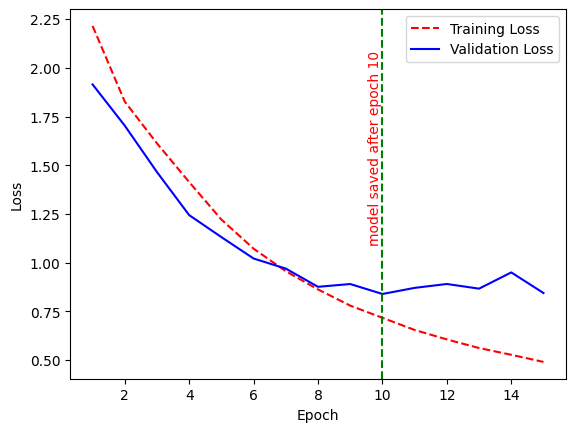

In [23]:
epoch_count = range(1, 16)

# Visualize loss history
plt.plot(epoch_count, train_losses, 'r--')
plt.plot(epoch_count, valid_losses, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.axvline(x=10, color='g', linestyle='--')

# Add text
plt.text(10, max(train_losses)/2, 'model saved after epoch 10', color='r',
         rotation='vertical', horizontalalignment='right')
plt.show()